# LangGraph Multi-Agent System with Supervisor Quality Control for Yelp Navigator

## Overview
This notebook implements a sophisticated multi-agent system using LangGraph that:
1. **Clarifies user intent** through an intelligent agent (with fallback defaults)
2. **Coordinates multiple agents** that interact with pipeline endpoints
3. **Routes conditionally** based on detail level requirements
4. **Reviews and approves** outputs with supervisor quality control
5. **Synthesizes results** into human-readable summaries

## Architecture
```
User Query
    ↓
Clarification Agent (identifies: query, location, detail level)
    ├─ Attempts to extract info from query
    └─ Falls back to defaults after 2 attempts (prevents infinite loops)
    ↓
Search Agent (always runs first)
    ↓
┌────────────────┬─────────────────┐
↓                ↓                 ↓
Details Agent   Sentiment Agent   (conditional execution based on detail_level)
    ↓                ↓                 ↓
└────────────────┴─────────────────┴──────────────────┘
    ↓
Summary Agent (generates draft)
    ↓
Supervisor Approval ◄────────────────┐
    ├─ Approved? → END               │
    └─ Needs revision? ──────────────┘
       (routes back to appropriate agent)
```

## Prerequisites
- Hayhooks server running: `uv run hayhooks run --pipelines-dir pipelines`
- OpenAI API key configured
- LangGraph and LangChain packages installed

## Important Notes
- **Recursion Protection**: The clarification agent uses defaults after 2 attempts to prevent infinite loops
- **Quality Control**: Supervisor reviews summaries and can request revisions (max 2 approval attempts)
- **Single-Shot Execution**: This notebook uses batch processing (not interactive chat)
- **For Interactive Clarification**: See the note later in the notebook about using LangGraph interrupts or web frameworks


## Setup and Imports

In [1]:
import os
import json
import requests
from typing import Annotated, Literal, TypedDict, List, Dict, Any
from operator import add

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent
from dotenv import load_dotenv

load_dotenv(".env")

# Configuration
BASE_URL = "http://localhost:1416"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    print("⚠️ Warning: OPENAI_API_KEY not set. Please set it in your environment.")
else:
    print("✅ OpenAI API key configured")

✅ OpenAI API key configured


## State Schema Definition

The state tracks the entire workflow, including:
- **messages**: Conversation history
- **user_query**: Original user question
- **clarified_query**: Extracted search query
- **clarified_location**: Extracted location
- **detail_level**: Required detail level (general/detailed/reviews)
- **clarification_complete**: Flag indicating clarification phase is done
- **agent_outputs**: Results from each specialized agent
- **final_summary**: Human-readable final answer

In [2]:
class AgentState(TypedDict):
    """State for the multi-agent system."""
    # Conversation tracking
    messages: Annotated[List[BaseMessage], add]
    
    # User intent
    user_query: str
    clarified_query: str  # What they're looking for (e.g., "Mexican food")
    clarified_location: str  # Where (e.g., "Austin, Texas")
    
    # Detail level: "general", "detailed", or "reviews"
    detail_level: str
    
    # Workflow control
    clarification_complete: bool
    next_agent: str  # Which agent to call next
    
    # Results from agents
    agent_outputs: Dict[str, Any]
    
    # Final output
    final_summary: str
    
    # Supervisor approval tracking
    approval_attempts: int  # Track how many times supervisor has reviewed
    needs_revision: bool  # Flag indicating if summary needs improvement
    revision_feedback: str  # What needs to be improved


## Tool Definitions: Pipeline Endpoints as Tools

Each pipeline endpoint is wrapped as a LangChain tool that agents can use.

In [3]:
@tool
def search_businesses(query: str) -> Dict[str, Any]:
    """Search for businesses using natural language query.
    
    Args:
        query: Natural language search query (e.g., 'Mexican food in Austin, Texas')
        
    Returns:
        Dictionary containing business search results with names, ratings, locations, etc.
    """
    try:
        response = requests.post(
            f"{BASE_URL}/business_search/run",
            json={"query": query},
            timeout=30
        )
        
        if response.status_code == 200:
            data = response.json()
            result = data.get('result', {})
            
            # Extract key information for the agent
            businesses = result.get('businesses', [])
            return {
                "success": True,
                "result_count": result.get('result_count', 0),
                "extracted_location": result.get('extracted_location', ''),
                "extracted_keywords": result.get('extracted_keywords', []),
                "businesses": [
                    {
                        "name": b.get('name'),
                        "rating": b.get('rating'),
                        "review_count": b.get('review_count'),
                        "categories": b.get('categories', []),
                        "price_range": b.get('price_range', 'N/A'),
                        "phone": b.get('phone', 'N/A'),
                        "location": b.get('location', {})
                    }
                    for b in businesses[:10]  # Limit to first 10 for context
                ],
                "full_output": data  # Store full output for downstream pipelines
            }
        else:
            return {"success": False, "error": f"API returned status {response.status_code}"}
    except Exception as e:
        return {"success": False, "error": str(e)}


@tool
def get_business_details(pipeline1_output: Dict[str, Any]) -> Dict[str, Any]:
    """Get detailed information about businesses including website content.
    
    Args:
        pipeline1_output: Output from the search_businesses tool
        
    Returns:
        Dictionary with enriched business details including website content
    """
    try:
        response = requests.post(
            f"{BASE_URL}/business_details/run",
            json={"pipeline1_output": pipeline1_output},
            timeout=60
        )
        
        if response.status_code == 200:
            data = response.json()
            documents = data.get('metadata_enricher', {}).get('documents', [])
            
            return {
                "success": True,
                "document_count": len(documents),
                "businesses_with_details": [
                    {
                        "name": doc.get('meta', {}).get('business_name'),
                        "price_range": doc.get('meta', {}).get('price_range'),
                        "rating": doc.get('meta', {}).get('rating'),
                        "website_content_length": len(doc.get('content', '')),
                        "has_website_info": len(doc.get('content', '')) > 0
                    }
                    for doc in documents[:5]
                ],
                "full_output": data
            }
        else:
            return {"success": False, "error": f"API returned status {response.status_code}"}
    except Exception as e:
        return {"success": False, "error": str(e)}


@tool
def analyze_reviews_sentiment(pipeline1_output: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze customer reviews and sentiment for businesses.
    
    Args:
        pipeline1_output: Output from the search_businesses tool
        
    Returns:
        Dictionary with sentiment analysis and review summaries
    """
    try:
        response = requests.post(
            f"{BASE_URL}/business_sentiment/run",
            json={"pipeline1_output": pipeline1_output},
            timeout=120
        )
        
        if response.status_code == 200:
            data = response.json()
            documents = data.get('reviews_aggregator', {}).get('documents', [])
            
            return {
                "success": True,
                "analyzed_count": len(documents),
                "sentiment_summaries": [
                    {
                        "name": doc.get('meta', {}).get('business_name'),
                        "positive_count": doc.get('meta', {}).get('positive_count', 0),
                        "neutral_count": doc.get('meta', {}).get('neutral_count', 0),
                        "negative_count": doc.get('meta', {}).get('negative_count', 0),
                        "top_positive_reviews": doc.get('meta', {}).get('top_positive_reviews', [])[:2],
                        "bottom_negative_reviews": doc.get('meta', {}).get('bottom_negative_reviews', [])[:2]
                    }
                    for doc in documents[:5]
                ],
                "full_output": data
            }
        else:
            return {"success": False, "error": f"API returned status {response.status_code}"}
    except Exception as e:
        return {"success": False, "error": str(e)}

## Initialize LLM

In [4]:
# Initialize the language model
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Agent 1: Clarification Agent

This agent interacts with the user to identify:
1. **Query**: What are they looking for?
2. **Location**: Where?
3. **Detail Level**: What kind of information do they need?

In [5]:
def clarification_agent(state: AgentState) -> AgentState:
    """Agent that clarifies user intent before delegating to specialized agents."""
    
    # Check if this is the first interaction
    user_query = state.get("user_query", "")
    
    # Count how many clarification attempts have been made
    messages = state.get("messages", [])
    clarification_attempts = sum(1 for m in messages if isinstance(m, AIMessage) and "CLARIFIED:" not in m.content)
    
    # If we've tried too many times, make best guess with defaults
    if clarification_attempts >= 2:
        # Force completion with reasonable defaults
        return {
            "messages": [AIMessage(content="⚠️ Using default values: searching for restaurants in United States with general detail level.")],
            "clarified_query": "restaurants",
            "clarified_location": "United States",
            "detail_level": "general",
            "clarification_complete": True,
            "next_agent": "search"
        }
    
    # System prompt for clarification
    system_prompt = """You are a helpful assistant that clarifies user requests for business searches.
    
Your goal is to extract three pieces of information:
1. QUERY: What type of business/food/service are they looking for?
2. LOCATION: Where are they searching?
3. DETAIL_LEVEL: What information do they need?
   - "general": Just basic business info (name, rating, location)
   - "detailed": Include website information and additional details
   - "reviews": Include customer reviews and sentiment analysis

Analyze the user's query and extract this information. If the query is too vague and missing critical information,
you should make reasonable assumptions and proceed rather than asking for clarification.

For example:
- If they say "restaurants" without a location, use "United States" as default
- If they don't specify detail level, use "general"
- If they mention wanting "reviews" or "what people say", use "reviews" detail level

When you have all information (or can make reasonable assumptions), respond EXACTLY in this format:
CLARIFIED:
QUERY: [what they're looking for]
LOCATION: [where]
DETAIL_LEVEL: [general/detailed/reviews]
"""
    
    msg_list = [SystemMessage(content=system_prompt)]
    msg_list.extend(messages)
    
    # If this is the first turn, add the user query
    if user_query and not any(isinstance(m, HumanMessage) for m in messages):
        msg_list.append(HumanMessage(content=user_query))
    
    # Get LLM response
    response = llm.invoke(msg_list)
    
    # Check if clarification is complete
    response_text = response.content
    
    if "CLARIFIED:" in response_text:
        # Parse the clarified information
        lines = response_text.split('\n')
        clarified_info = {}
        
        for line in lines:
            if line.startswith("QUERY:"):
                clarified_info['query'] = line.replace("QUERY:", "").strip()
            elif line.startswith("LOCATION:"):
                clarified_info['location'] = line.replace("LOCATION:", "").strip()
            elif line.startswith("DETAIL_LEVEL:"):
                clarified_info['detail_level'] = line.replace("DETAIL_LEVEL:", "").strip().lower()
        
        return {
            "messages": [response],
            "clarified_query": clarified_info.get('query', 'restaurants'),
            "clarified_location": clarified_info.get('location', 'United States'),
            "detail_level": clarified_info.get('detail_level', 'general'),
            "clarification_complete": True,
            "next_agent": "search"
        }
    else:
        # Still clarifying
        return {
            "messages": [response],
            "clarification_complete": False,
            "next_agent": "clarification"
        }


## Specialized Agents with Tools

Each agent has access to one pipeline endpoint as a tool.

In [6]:
def search_agent_node(state: AgentState) -> AgentState:
    """Search agent that finds businesses."""
    
    clarified_query = state.get("clarified_query", "")
    clarified_location = state.get("clarified_location", "")
    full_query = f"{clarified_query} in {clarified_location}"
    
    # Call the search tool
    result = search_businesses.invoke({"query": full_query})
    
    # Store the result
    agent_outputs = state.get("agent_outputs", {})
    agent_outputs["search"] = result
    
    # Create summary message
    if result.get("success"):
        businesses = result.get("businesses", [])
        summary = f"""🔍 Search Agent Results:
Found {result.get('result_count', 0)} businesses total
Top {len(businesses)} results retrieved:
"""
        for i, biz in enumerate(businesses[:5], 1):
            summary += f"\n{i}. {biz['name']} - {biz['rating']}⭐ ({biz['review_count']} reviews) - {biz.get('price_range', 'N/A')}"
    else:
        summary = f"❌ Search failed: {result.get('error', 'Unknown error')}"
    
    # Determine next agent based on detail level
    detail_level = state.get("detail_level", "general")
    
    if detail_level == "general":
        next_agent = "summary"
    elif detail_level == "detailed":
        next_agent = "details"
    else:  # reviews
        next_agent = "details"
    
    return {
        "messages": [AIMessage(content=summary)],
        "agent_outputs": agent_outputs,
        "next_agent": next_agent
    }


def details_agent_node(state: AgentState) -> AgentState:
    """Details agent that fetches website information."""
    
    agent_outputs = state.get("agent_outputs", {})
    search_output = agent_outputs.get("search", {})
    
    if not search_output.get("success"):
        return {
            "messages": [AIMessage(content="⚠️ Skipping details - no search results available")],
            "next_agent": "summary"
        }
    
    # Get pipeline1 output from search results
    pipeline1_output = search_output.get("full_output", {})
    
    # Call the details tool with keyword argument
    result = get_business_details.invoke({"pipeline1_output": pipeline1_output})
    
    agent_outputs["details"] = result
    
    # Create summary message
    if result.get("success"):
        details = result.get("businesses_with_details", [])
        summary = f"""🌐 Details Agent Results:
Retrieved detailed information for {result.get('document_count', 0)} businesses:
"""
        for i, biz in enumerate(details[:3], 1):
            website_status = "✅ Has website content" if biz['has_website_info'] else "❌ No website info"
            summary += f"\n{i}. {biz['name']} - {website_status}"
    else:
        summary = f"❌ Details fetch failed: {result.get('error', 'Unknown error')}"
    
    # Determine next agent
    detail_level = state.get("detail_level", "general")
    next_agent = "sentiment" if detail_level == "reviews" else "summary"
    
    return {
        "messages": [AIMessage(content=summary)],
        "agent_outputs": agent_outputs,
        "next_agent": next_agent
    }


def sentiment_agent_node(state: AgentState) -> AgentState:
    """Sentiment agent that analyzes reviews."""
    
    agent_outputs = state.get("agent_outputs", {})
    search_output = agent_outputs.get("search", {})
    
    if not search_output.get("success"):
        return {
            "messages": [AIMessage(content="⚠️ Skipping sentiment analysis - no search results available")],
            "next_agent": "summary"
        }
    
    # Get pipeline1 output from search results
    pipeline1_output = search_output.get("full_output", {})
    
    # Call the sentiment tool with keyword argument
    result = analyze_reviews_sentiment.invoke({"pipeline1_output": pipeline1_output})
    
    agent_outputs["sentiment"] = result
    
    # Create summary message
    if result.get("success"):
        sentiments = result.get("sentiment_summaries", [])
        summary = f"""💬 Sentiment Agent Results:
Analyzed reviews for {result.get('analyzed_count', 0)} businesses:
"""
        for i, biz in enumerate(sentiments[:3], 1):
            total = biz['positive_count'] + biz['neutral_count'] + biz['negative_count']
            if total > 0:
                positive_pct = (biz['positive_count'] / total) * 100
                summary += f"\n{i}. {biz['name']}"
                summary += f"\n   Sentiment: {biz['positive_count']}😊 {biz['neutral_count']}😐 {biz['negative_count']}😞 ({positive_pct:.0f}% positive)"
    else:
        summary = f"❌ Sentiment analysis failed: {result.get('error', 'Unknown error')}"
    
    return {
        "messages": [AIMessage(content=summary)],
        "agent_outputs": agent_outputs,
        "next_agent": "summary"
    }


## Supervisor Approval Agent

After the summary is generated, the supervisor reviews it for completeness and quality.

In [7]:
def supervisor_approval_agent(state: AgentState) -> AgentState:
    """Supervisor reviews the summary and decides if it's complete or needs revision."""
    
    final_summary = state.get("final_summary", "")
    detail_level = state.get("detail_level", "general")
    agent_outputs = state.get("agent_outputs", {})
    clarified_query = state.get("clarified_query", "")
    clarified_location = state.get("clarified_location", "")
    approval_attempts = state.get("approval_attempts", 0)
    
    # Limit approval loops to prevent infinite cycles
    MAX_APPROVAL_ATTEMPTS = 2
    
    if approval_attempts >= MAX_APPROVAL_ATTEMPTS:
        return {
            "messages": [AIMessage(content="✅ Supervisor: Approval limit reached. Accepting current summary.")],
            "next_agent": "end",
            "approval_attempts": approval_attempts + 1
        }
    
    # Build evaluation context
    evaluation_prompt = f"""You are a supervisor reviewing a summary for quality and completeness.

USER REQUEST:
- Query: {clarified_query} in {clarified_location}
- Detail level: {detail_level}

AVAILABLE DATA:
- Search results: {"✓ Available" if agent_outputs.get("search", {}).get("success") else "✗ Not available"}
- Website details: {"✓ Available" if agent_outputs.get("details", {}).get("success") else "✗ Not available"}
- Review sentiment: {"✓ Available" if agent_outputs.get("sentiment", {}).get("success") else "✗ Not available"}

SUMMARY TO REVIEW:
{final_summary}

EVALUATION CRITERIA:
1. Does it directly answer the user's question?
2. Are the top recommendations clearly highlighted?
3. If detail_level is "detailed", does it mention website information?
4. If detail_level is "reviews", does it discuss customer sentiment and reviews?
5. Is it well-structured and easy to read?
6. Does it have a helpful closing statement?

Based on your evaluation, respond in ONE of these formats:

If the summary is complete and satisfactory:
APPROVED

If the summary needs improvement:
NEEDS_REVISION
FEEDBACK: [specific feedback on what to improve]
RERUN_AGENT: [which agent to rerun: "search", "details", "sentiment", or "summary"]
"""
    
    # Get supervisor's evaluation
    evaluation = llm.invoke([SystemMessage(content=evaluation_prompt)])
    evaluation_text = evaluation.content
    
    if "APPROVED" in evaluation_text and "NEEDS_REVISION" not in evaluation_text:
        # Summary approved!
        return {
            "messages": [AIMessage(content="✅ Supervisor: Summary approved! All requirements met.")],
            "next_agent": "end",
            "approval_attempts": approval_attempts + 1
        }
    
    # Summary needs revision
    feedback_lines = evaluation_text.split('\n')
    feedback = ""
    rerun_agent = "summary"  # Default to regenerating summary
    
    for line in feedback_lines:
        if line.startswith("FEEDBACK:"):
            feedback = line.replace("FEEDBACK:", "").strip()
        elif line.startswith("RERUN_AGENT:"):
            agent_name = line.replace("RERUN_AGENT:", "").strip().lower()
            if agent_name in ["search", "details", "sentiment", "summary"]:
                rerun_agent = agent_name
    
    if not feedback:
        feedback = "Please improve the summary to better address the user's requirements."
    
    supervisor_message = f"""⚠️ Supervisor: Summary needs revision.
Feedback: {feedback}
Action: Re-running {rerun_agent} agent..."""
    
    return {
        "messages": [AIMessage(content=supervisor_message)],
        "next_agent": rerun_agent,
        "needs_revision": True,
        "revision_feedback": feedback,
        "approval_attempts": approval_attempts + 1
    }


## Summary Agent

Synthesizes all agent outputs into a human-readable final answer.

In [8]:
def summary_agent_node(state: AgentState) -> AgentState:
    """Summary agent that creates the final human-readable response."""
    
    agent_outputs = state.get("agent_outputs", {})
    clarified_query = state.get("clarified_query", "")
    clarified_location = state.get("clarified_location", "")
    detail_level = state.get("detail_level", "general")
    needs_revision = state.get("needs_revision", False)
    revision_feedback = state.get("revision_feedback", "")
    
    # Build context for the LLM
    context = f"""Create a comprehensive, human-readable summary based on the following information:

User was looking for: {clarified_query} in {clarified_location}
Detail level requested: {detail_level}
"""
    
    # Add revision feedback if this is a revision
    if needs_revision and revision_feedback:
        context += f"\n⚠️ SUPERVISOR FEEDBACK (please address this):\n{revision_feedback}\n"
    
    context += "\nAgent Results:\n"
    
    # Add search results
    if "search" in agent_outputs and agent_outputs["search"].get("success"):
        search = agent_outputs["search"]
        context += f"\n\nSEARCH RESULTS ({search['result_count']} total found):\n"
        for i, biz in enumerate(search.get("businesses", [])[:5], 1):
            context += f"{i}. {biz['name']}\n"
            context += f"   Rating: {biz['rating']} stars ({biz['review_count']} reviews)\n"
            context += f"   Price: {biz.get('price_range', 'N/A')}\n"
            context += f"   Categories: {', '.join(biz.get('categories', []))}\n"
            context += f"   Phone: {biz.get('phone', 'N/A')}\n\n"
    
    # Add details if available
    if "details" in agent_outputs and agent_outputs["details"].get("success"):
        details = agent_outputs["details"]
        context += "\n\nDETAILED INFORMATION:\n"
        for i, biz in enumerate(details.get("businesses_with_details", [])[:3], 1):
            context += f"{i}. {biz['name']}\n"
            if biz['has_website_info']:
                context += f"   ✓ Website information available ({biz['website_content_length']} chars)\n"
            else:
                context += f"   ✗ No website information found\n"
    
    # Add sentiment if available
    if "sentiment" in agent_outputs and agent_outputs["sentiment"].get("success"):
        sentiment = agent_outputs["sentiment"]
        context += "\n\nREVIEW SENTIMENT ANALYSIS:\n"
        for i, biz in enumerate(sentiment.get("sentiment_summaries", [])[:3], 1):
            context += f"{i}. {biz['name']}\n"
            context += f"   Positive: {biz['positive_count']}, Neutral: {biz['neutral_count']}, Negative: {biz['negative_count']}\n"
            
            # Add sample reviews
            if biz.get('top_positive_reviews'):
                context += f"   Top Review: {biz['top_positive_reviews'][0].get('text', '')[:150]}...\n"
            if biz.get('bottom_negative_reviews'):
                context += f"   Critical Review: {biz['bottom_negative_reviews'][0].get('text', '')[:150]}...\n"
    
    context += """\n\nPlease write a comprehensive, friendly summary that:
1. Directly answers the user's question
2. Highlights the top 3-5 recommendations
3. Includes relevant details based on what was requested
4. Is easy to read and conversational
5. Ends with a helpful closing statement
"""
    
    # Generate summary using LLM
    response = llm.invoke([SystemMessage(content=context)])
    final_summary = response.content
    
    return {
        "messages": [AIMessage(content=f"\n\n📝 SUMMARY DRAFT:\n\n{final_summary}")],
        "final_summary": final_summary,
        "next_agent": "supervisor_approval",
        "needs_revision": False  # Reset flag after generating new summary
    }


## Build the LangGraph Workflow

Now we connect all agents in a graph with conditional routing.

In [9]:
def route_after_clarification(state: AgentState) -> str:
    """Route to search if clarification is complete, otherwise continue clarifying."""
    if state.get("clarification_complete", False):
        return "search"
    return "clarification"


def route_from_agents(state: AgentState) -> str:
    """Route to the next agent based on state."""
    next_agent = state.get("next_agent", "end")
    
    if next_agent == "end":
        return END
    
    return next_agent


def route_from_supervisor_approval(state: AgentState) -> str:
    """Route from supervisor approval to either END or back to an agent."""
    next_agent = state.get("next_agent", "end")
    
    if next_agent == "end":
        return END
    
    # Supervisor wants to rerun an agent
    return next_agent


# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("clarification", clarification_agent)
workflow.add_node("search", search_agent_node)
workflow.add_node("details", details_agent_node)
workflow.add_node("sentiment", sentiment_agent_node)
workflow.add_node("summary", summary_agent_node)
workflow.add_node("supervisor_approval", supervisor_approval_agent)

# Add edges
workflow.add_edge(START, "clarification")

# Conditional routing from clarification - goes directly to search when complete
workflow.add_conditional_edges(
    "clarification",
    route_after_clarification,
    {"clarification": "clarification", "search": "search"}
)

# Conditional routing from specialized agents
workflow.add_conditional_edges(
    "search",
    route_from_agents,
    {"details": "details", "sentiment": "sentiment", "summary": "summary", END: END}
)

workflow.add_conditional_edges(
    "details",
    route_from_agents,
    {"sentiment": "sentiment", "summary": "summary", END: END}
)

workflow.add_conditional_edges(
    "sentiment",
    route_from_agents,
    {"summary": "summary", END: END}
)

# Summary now routes to supervisor approval instead of END
workflow.add_conditional_edges(
    "summary",
    route_from_agents,
    {"supervisor_approval": "supervisor_approval", END: END}
)

# Supervisor approval can route back to agents or to END
workflow.add_conditional_edges(
    "supervisor_approval",
    route_from_supervisor_approval,
    {
        "search": "search",
        "details": "details", 
        "sentiment": "sentiment",
        "summary": "summary",
        END: END
    }
)

# Compile the graph with increased recursion limit for approval loops
app = workflow.compile()

print("✅ Multi-agent workflow with supervisor approval compiled successfully!")
print("⚙️  Recursion limit: 25 (default)")
print("💡 Clarification agent will use defaults after 2 attempts to prevent infinite loops")
print("🔄 Supervisor approval will review summaries and can request revisions (max 2 approval attempts)")
print("📍 Workflow now routes directly from clarification to search (supervisor delegation node removed)")


✅ Multi-agent workflow with supervisor approval compiled successfully!
⚙️  Recursion limit: 25 (default)
💡 Clarification agent will use defaults after 2 attempts to prevent infinite loops
🔄 Supervisor approval will review summaries and can request revisions (max 2 approval attempts)
📍 Workflow now routes directly from clarification to search (supervisor delegation node removed)


## Visualize the Graph

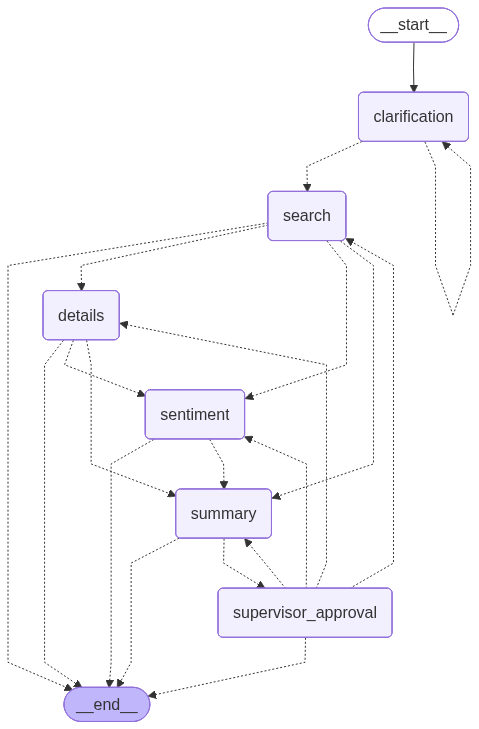

In [10]:
# Display the graph structure
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(app.get_graph())

## Example 1: General Search (Basic Information Only)

In [11]:
# Example 1: User wants basic business information
result = app.invoke({
    "user_query": "I'm looking for good Mexican restaurants in Austin, Texas. Just need basic info like ratings and locations.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

# Display the conversation and results
print("\n" + "="*80)
print("EXAMPLE 1: GENERAL SEARCH")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)


EXAMPLE 1: GENERAL SEARCH


Assistant:
CLARIFIED:
QUERY: Mexican restaurants
LOCATION: Austin, Texas
DETAIL_LEVEL: general
--------------------------------------------------------------------------------

Assistant:
🔍 Search Agent Results:
Found 240 businesses total
Top 10 results retrieved:

1. Moonshine Grill - 4.4⭐ (6312 reviews) - $$
2. 1618 Asian Fusion - 4.7⭐ (3855 reviews) - $$
3. Red Ash - 4.4⭐ (1497 reviews) - $$$$
4. Aba - 4.4⭐ (1761 reviews) - $$$
5. Qi Austin - 4.4⭐ (849 reviews) - $$
--------------------------------------------------------------------------------

Assistant:


📝 SUMMARY DRAFT:

It looks like you're on the hunt for some delicious Mexican cuisine in Austin, Texas! While the search results provided don't specifically list Mexican restaurants, Austin is known for its vibrant food scene, and there are plenty of fantastic options to explore. Here are a few top recommendations to get you started on your culinary adventure:

1. **Fonda San Miguel** - This iconic 

## Example 2: Detailed Search (With Website Information)

In [ ]:
# Example 2: User wants detailed information including websites
result = app.invoke({
    "user_query": "Find me Italian restaurants in San Francisco. I need detailed information including their websites.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 2: DETAILED SEARCH")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)

## Example 3: Full Analysis (With Reviews and Sentiment)

In [12]:
# Example 3: User wants complete analysis including reviews
result = app.invoke({
    "user_query": "What are the best coffee shops in Portland, Oregon? I want to see customer reviews and what people are saying about them.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 3: FULL ANALYSIS WITH REVIEWS")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)

# Also show the final summary explicitly
if result.get("final_summary"):
    print("\n" + "#"*80)
    print("FINAL SUMMARY FOR THE USER:")
    print("#"*80)
    print(result["final_summary"])


EXAMPLE 3: FULL ANALYSIS WITH REVIEWS


Assistant:
CLARIFIED:
QUERY: coffee shops
LOCATION: Portland, Oregon
DETAIL_LEVEL: reviews
--------------------------------------------------------------------------------

Assistant:
🔍 Search Agent Results:
Found 240 businesses total
Top 10 results retrieved:

1. Soro Soro Coffee & Dessert - 4.6⭐ (434 reviews) - $$
2. La Lucha Coffee - 5.0⭐ (18 reviews) - None
3. Roseline Coffee - 4.5⭐ (32 reviews) - None
4. Coava Coffee Roasters - 4.4⭐ (889 reviews) - $$
5. Phin Caphe & Boba - 4.4⭐ (132 reviews) - $$
--------------------------------------------------------------------------------

Assistant:
🌐 Details Agent Results:
Retrieved detailed information for 0 businesses:

--------------------------------------------------------------------------------

Assistant:
💬 Sentiment Agent Results:
Analyzed reviews for 0 businesses:

--------------------------------------------------------------------------------

Assistant:


📝 SUMMARY DRAFT:

If you're on t

## Example 4: Ambiguous Query with Default Fallback

Demonstrates how the system handles ambiguous queries. The clarification agent will:
1. Try to extract information from the vague query
2. Use reasonable defaults if information is missing
3. Proceed with the search after a maximum of 2 clarification attempts

**Note**: For truly interactive clarification with back-and-forth conversation, you would need to use LangGraph's streaming mode or a web interface. This notebook demonstrates the fallback behavior that prevents infinite loops.


In [ ]:
# Example 4: Ambiguous query that triggers default fallback behavior
result = app.invoke({
    "user_query": "I want to find some good restaurants.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 4: AMBIGUOUS QUERY WITH DEFAULT FALLBACK")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)

# Show the clarification results
print("\n" + "="*80)
print("CLARIFICATION RESULTS:")
print("="*80)
print(f"Query: {result.get('clarified_query', 'N/A')}")
print(f"Location: {result.get('clarified_location', 'N/A')}")
print(f"Detail Level: {result.get('detail_level', 'N/A')}")
print(f"Clarification Complete: {result.get('clarification_complete', False)}")


## Note on Interactive Clarification

The examples above use a **single-shot invocation** approach where the graph runs to completion. For true interactive clarification (where the agent asks a question and waits for the user to respond), you would need to:

### Option 1: Use LangGraph's Interrupt Mechanism
```python
# Add interrupt_before to pause execution
app_with_interrupts = workflow.compile(
    checkpointer=MemorySaver(),  # Required for interrupts
    interrupt_before=["clarification"]
)

# First invocation - runs until clarification
result = app_with_interrupts.invoke(
    {"user_query": "I want restaurants"},
    config={"configurable": {"thread_id": "user_123"}}
)

# User provides more info
# Second invocation - continues from where it left off
result = app_with_interrupts.invoke(
    {"messages": [HumanMessage("I'm looking in Seattle")]},
    config={"configurable": {"thread_id": "user_123"}}
)
```

### Option 2: Use LangGraph Streaming
Stream the graph execution and collect user input between steps.

### Option 3: Web Application
Build a web interface (e.g., with Chainlit, Streamlit, or FastAPI) that:
- Sends the initial query
- Displays agent questions
- Collects user responses
- Continues the conversation

For this notebook, we use the **fallback approach** where the agent makes reasonable assumptions to prevent infinite loops, which is suitable for batch processing and demonstration purposes.


## Example 5: Supervisor Approval in Action

This example shows how the supervisor reviews the summary and may request revisions.

In [ ]:
# Example 5: Watch the supervisor review and approve the summary
result = app.invoke({
    "user_query": "Find me vegetarian restaurants in Boston. I want detailed information with reviews.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False,
    "approval_attempts": 0
})

print("\n" + "="*80)
print("EXAMPLE 5: SUPERVISOR APPROVAL WORKFLOW")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)

# Show approval status
print("\n" + "="*80)
print("APPROVAL STATUS:")
print("="*80)
print(f"Approval Attempts: {result.get('approval_attempts', 0)}")
print(f"Final Status: {'Approved' if result.get('next_agent') == 'end' else 'Needs Revision'}")


## Helper Function: Run Complete Workflow

In [ ]:
def run_multiagent_query(user_query: str, verbose: bool = True) -> Dict[str, Any]:
    """
    Run a complete multi-agent workflow for a user query.
    
    Args:
        user_query: The user's natural language query
        verbose: Whether to print intermediate steps
        
    Returns:
        Complete state including final summary
    """
    result = app.invoke({
        "user_query": user_query,
        "messages": [],
        "agent_outputs": {},
        "clarification_complete": False
    })
    
    if verbose:
        print("\n" + "="*80)
        print(f"QUERY: {user_query}")
        print("="*80 + "\n")
        
        for msg in result["messages"]:
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            print(f"\n{role}:")
            print(msg.content)
            print("-" * 80)
    
    return result

## Advanced: Custom Configuration

You can customize the graph behavior with configuration options.


In [ ]:
# Example: Running with custom recursion limit
# If you need more steps (e.g., for complex clarification scenarios)

result = app.invoke(
    {
        "user_query": "Find me pizza in NYC",
        "messages": [],
        "agent_outputs": {},
        "clarification_complete": False
    },
    config={
        "recursion_limit": 50  # Increase from default 25 if needed
    }
)

print("Query processed successfully with custom config!")
print(f"Clarified Query: {result.get('clarified_query')}")
print(f"Location: {result.get('clarified_location')}")


## Test Custom Queries

In [ ]:
# Try your own query here!
my_result = run_multiagent_query(
    "Find me the best sushi restaurants in Seattle with great reviews",
    verbose=True
)

## Key Takeaways

### Architecture Highlights

1. **Clarification Phase**: The system first ensures it understands:
   - What the user is looking for
   - Where they want to search
   - How much detail they need
   - **Has fallback mechanism**: After 2 attempts, uses defaults to prevent infinite loops

2. **Conditional Routing**: Based on detail level requirements:
   - Search Agent always runs first after clarification
   - Details Agent activates conditionally (for "detailed" or "reviews" level)
   - Sentiment Agent activates conditionally (only for "reviews" level)

3. **Tool-Enabled Agents**: Each specialized agent:
   - Has access to one pipeline endpoint as a tool
   - Can only perform its designated task
   - Passes results through the state

4. **Summary Generation**: The Summary Agent:
   - Collects all agent outputs
   - Uses LLM to create a coherent, human-readable response
   - Tailors the summary to the requested detail level
   - Can incorporate revision feedback from supervisor

5. **Supervisor Approval Loop**: The Supervisor reviews summaries for:
   - Completeness relative to user requirements
   - Appropriate use of available data
   - Quality and readability
   - Can request revisions by routing back to specific agents
   - Maximum 2 approval attempts to prevent infinite loops

### Advantages of This Approach

- **Modularity**: Each agent is independent and focused
- **Flexibility**: Easy to add new agents or modify existing ones
- **Efficiency**: Only runs necessary agents based on requirements
- **User-Friendly**: Clarification phase ensures accurate results
- **Scalability**: Can handle parallel execution of independent agents
- **Robustness**: Multiple fallback mechanisms prevent infinite loops
- **Quality Control**: Supervisor approval ensures output meets requirements

### Potential Enhancements

- Add memory/checkpointing for multi-turn conversations
- Implement true interactive clarification with interrupts
- Implement parallel execution of Details and Sentiment agents
- Add error recovery and retry logic
- Include user feedback loop for result refinement
- Add more specialized agents (e.g., price comparison, distance calculation)
- Integrate with web framework for real-time user interaction
- Allow supervisor to request specific data from agents not yet run


## Debugging and Inspection

Useful cells for debugging the workflow.

In [ ]:
# Inspect the last result's state
def inspect_result(result: Dict[str, Any]):
    """Print a detailed breakdown of the result state."""
    print("\n" + "="*80)
    print("STATE INSPECTION")
    print("="*80)
    
    print(f"\n🎯 Clarified Query: {result.get('clarified_query', 'N/A')}")
    print(f"📍 Clarified Location: {result.get('clarified_location', 'N/A')}")
    print(f"📊 Detail Level: {result.get('detail_level', 'N/A')}")
    print(f"✅ Clarification Complete: {result.get('clarification_complete', False)}")
    
    print(f"\n🤖 Active Agents:")
    agent_outputs = result.get('agent_outputs', {})
    for agent_name, output in agent_outputs.items():
        success = output.get('success', False)
        status = "✅" if success else "❌"
        print(f"  {status} {agent_name.upper()} Agent")
    
    print(f"\n💬 Message Count: {len(result.get('messages', []))}")
    print(f"📝 Final Summary Length: {len(result.get('final_summary', ''))} characters")

# Example usage:
# inspect_result(my_result)

## Conclusion

This notebook demonstrates a production-ready multi-agent system that:
- Clarifies user intent before taking action (with smart defaults for ambiguous queries)
- Coordinates multiple specialized agents through a supervisor
- Integrates with existing pipeline endpoints
- **Reviews and approves outputs** with supervisor quality control loops
- Produces human-readable summaries
- Includes multiple safeguards against infinite loops

### Key Innovation: Supervisor Approval Loop

The supervisor approval mechanism ensures quality by:
- Evaluating summaries against user requirements
- Checking that appropriate detail level is provided
- Verifying all available data is utilized
- Providing specific feedback for revisions
- Routing back to specific agents when improvements are needed

This creates a **self-correcting system** that iteratively improves output quality while maintaining efficiency through approval attempt limits.

### Limitations in Jupyter Notebook Context

This implementation uses a **single-shot approach** where queries are processed to completion. For truly interactive, back-and-forth clarification conversations, you would need:
- LangGraph's interrupt/checkpointing mechanisms
- A web application framework (Chainlit, Streamlit, FastAPI)
- Streaming capabilities for real-time interaction

The fallback mechanisms (using defaults after 2 clarification attempts, limiting to 2 approval attempts) are pragmatic solutions for batch processing and demonstration purposes.

### Next Steps

The system is extensible and can be adapted for:
- Other business search domains (hotels, services, etc.)
- Different types of multi-agent workflows with quality control
- Integration with web applications for interactive use
- Production deployment with proper error handling and monitoring
- A/B testing different supervisor approval criteria
- Human-in-the-loop approval for sensitive applications
